<a href="https://colab.research.google.com/github/faisalrasbihan/gru-momentum-clean-slate/blob/master/gru10_clean_slate_REGRESSION-always61.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preamble

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from numpy import ones,vstack
from numpy.linalg import lstsq
import missingno as msno
from tqdm import tqdm
import math

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Conv1D, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

# Data Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from itertools import combinations_with_replacement 
import multiprocessing

# Math & Stats
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score
from scipy import stats

sns.set()

# 1. Import Data

In [2]:
# Read CSV - LQ45 Historical Data
df = pd.read_csv('LQ45_20210309.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.set_index('Date').sort_index().rename(columns={"Price": "Close"})
df.drop(['LQ45_Vol'],axis=1,inplace=True)

# read IDX30 data
IDX30 = pd.read_csv('IDX30_20210309.csv').rename(columns={"IDX30_Vol": "Volume"})
IDX30['Date'] = pd.to_datetime(IDX30['Date'], format='%d/%m/%Y')
IDX30 = IDX30.set_index('Date').sort_index().rename(columns={"Price": "IDX30"})

# read IHSG data
IHSG = pd.read_csv('IHSG_20210309.csv')
IHSG['Date'] = pd.to_datetime(IHSG['Date'], format='%d/%m/%Y')
IHSG = IHSG.set_index('Date').sort_index().rename(columns={"Price": "IHSG"})

IDX30.replace(0, np.nan, inplace=True)
IDX30['Volume'] = IDX30['Volume']/1000000000
IDX30.loc[IDX30.Volume > 13, 'Volume'] = np.nan

IDX30 = IDX30[['IDX30','Volume']]
IHSG = IHSG[['IHSG']]

# read EIDO data
EIDO = pd.read_csv('EIDO_20210309.csv')
EIDO['Date'] = pd.to_datetime(EIDO['Date'], format='%d/%m/%Y')
EIDO = EIDO.set_index('Date').sort_index().rename(columns={"Price": "EIDO"})

# read SPY data
SPY = pd.read_csv('SPY_20210309.csv')
SPY['Date'] = pd.to_datetime(SPY['Date'], format='%d/%m/%Y')
SPY = SPY.set_index('Date').sort_index().rename(columns={"Price": "SPY"})

# read JCI data
jci_value = pd.read_csv('JCI_value.csv')
jci_value['date'] = pd.to_datetime(jci_value['date'], format='%d/%m/%Y')
jci_value = jci_value.set_index('date').sort_index()

SPY = SPY[['SPY']]#.resample('D').mean().shift(1).fillna(method='ffill')
EIDO = EIDO[['EIDO']]#.resample('D').mean().shift(1).fillna(method='ffill')

In [3]:
# Merge dataset
df = df.merge(SPY, how='outer', left_index=True, right_index=True).copy()
df = df.merge(EIDO, how='outer', left_index=True, right_index=True).copy()
df = df.merge(IHSG, how='left', left_index=True, right_index=True).copy()
df = df.merge(IDX30, how='left', left_index=True, right_index=True).copy()
df = df.merge(jci_value[['for_flow','dom_total','tot_buy']], how='left', left_index=True, right_index=True).copy()

# 2. Helper Functions

In [4]:
def sign_accuracy(true,pred):
    true = (true*STD) + MEAN
    pred = (pred*STD) + MEAN
    return K.mean(K.equal(K.sign(true), K.sign(pred)))

In [5]:
def generate_prediction(m, X, y, dates=dt.datetime(2012, 5, 1)):
    pred = m.predict(X)[:,0]
    true = y[:,0]
    train_result = pd.DataFrame()
    train_result['Close'] = X[:,-1,-1]
    train_result['true_bin'] = np.where(true < 0, -1, 1)
    train_result['pred_bin'] = np.where(pred < 0, -1, 1)
    train_result['true']  = true
    train_result['pred'] = pred
    train_result['mse'] = np.abs(train_result['true'] - train_result['pred']).rolling(7).sum()
    train_result['squared_hinge'] = 1 - train_result['true'] * train_result['pred']
    train_result.loc[train_result['squared_hinge'] < 0,'squared_hinge'] = 0
    train_result['squared_hinge'] = train_result['squared_hinge']**2
    train_result['rolling_error'] = train_result['squared_hinge'].rolling(7).mean()
    train_result['date'] = dates
    train_result['date_str'] = train_result['date'].dt.strftime('%Y-%m-%d')
    train_result['date_to_val'] = train_result['date'].map(pd.Series(data=np.arange(len(train_result)), 
                                                                     index=train_result['date'].values).to_dict())
    return pred,true,train_result

In [6]:
def create_model(neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(neurons, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dense(output_timesteps, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [7]:
def multi_gru_model(neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(50, return_sequences=True, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dropout(0.2))
    model.add(GRU(50, activation='linear'))
    model.add(Dropout(0.2))
    model.add(Dense(output_timesteps, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [8]:
def multi_layer_model(gru_neurons,hidden_neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(gru_neurons, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dense(hidden_neurons, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [9]:
MEAN_pre_filtered = 0.06968521192214656
STD_pre_filtered = 2.3073312870270306

def target_inverse_transform(x, mean=MEAN_pre_filtered, std=STD_pre_filtered):
    return (x*STD) + MEAN

def target_transform(x, mean=MEAN_pre_filtered, std=STD_pre_filtered):
    return (x - MEAN)/STD

In [10]:
def train_test_date_split(df_orig, range1='2020-01-01', range2='2019-01-01', range3='2020-01-01', range4='2021-02-01'):
    df = df_orig.copy()
    df_train = df[(df.index < range1)].copy()
    df_test = df[(df.index >= range2) & (df.index < range3)].copy()
    df_test2 = df[(df.index >= range3) & (df.index < range4)].copy()
    return df_train, df_test, df_test2

In [11]:
def hampel(vals_orig, k=7, t0=3):
    #Make copy so original not edited
    vals = vals_orig.copy()
    
    #Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)
    
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    return outlier_idx, vals

In [12]:
def generate_batch(data, input_timesteps, output_timesteps,input_variables, output_variables):
    '''
    Inputs a dataframe with desired sequence length and target name
    Yield a generator of training data from filename on given list of cols split for train/test
    outputs Sequence of data with corresponding target
    '''
    X, y = list(), list()
    target = data[output_variables].values
    data = data[input_variables].values
    # Iterate 
    for i in range(len(data) - (input_timesteps + output_timesteps) + 1):
        end_seq_x = i + input_timesteps
        end_seq_y = end_seq_x + output_timesteps
        # Input sequence starts from i to (i + input_timesteps - 1)
        seq_x = data[i:end_seq_x]
        # Target sequence starts after end of input sequence to end_ix + output_timesteps
        seq_y = target[end_seq_x:end_seq_y]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [13]:
def display_confusion_matrix(conf_matrix, reverse_ylabel=False, reverse_xlabel=False):
    labels = ['Negatives','Positives']
    sns.heatmap(conf_matrix, 
                annot=True, 
                cmap="Blues",
                fmt="d",vmin=0, 
                annot_kws={"size": 20}, 
                xticklabels = labels[::-1] if reverse_xlabel else labels, 
                yticklabels= labels[::-1] if reverse_ylabel else labels)
    plt.xlabel('Predicted Values', fontsize = 12) # x-axis label with fontsize 15
    plt.ylabel('Actual Values', fontsize = 12) # y-axis label with fontsize 15
    plt.show()

# 3. Feature Engineering

In [14]:
# Filter volume
outlier_idx, dom_filtered = hampel(df.dom_total,k=20,t0=9)
dom_outlier = df.dom_total.copy()
dom_outlier[~outlier_idx] = np.nan
df['dom_filtered'] = dom_filtered

outlier_idx, for_filtered = hampel(df.for_flow,k=20,t0=9)
for_outlier = df.for_flow.copy()
for_outlier[~outlier_idx] = np.nan
df['for_flow_filtered'] = for_filtered

outlier_idx, total_buy_filtered = hampel(df.tot_buy,k=20,t0=9)
tot_outlier = df.tot_buy.copy()
tot_outlier[~outlier_idx] = np.nan
df['total_buy_filtered'] = total_buy_filtered

In [15]:
# Resample Date to fill missing date
df = df.resample('D').mean()

# Interpolate Close and Volume Values
df.interpolate(inplace=True)

# Remove saturday and sunday data
df['day_of_week'] = df.index.dayofweek + 1
df = df[df['day_of_week'] < 6].copy()
df.drop(columns=['day_of_week'],inplace=True)

df = df[df.index >= '2012-04-24'].copy()

## 3.3 Create Engineered Features

In [16]:
MA_PERIOD = 5
FUTURE_DAYS = 3

df['momentum'] = df['Close'] - df['Close'].rolling(window=MA_PERIOD).mean()
# df['price_volatility'] = df['1day_price_change'].rolling(10).std()
df['linear_series'] = (df.reset_index().index + 1000) / 1000
# df['target'] = df['Close'].pct_change(periods=FUTURE_DAYS).shift(-(FUTURE_DAYS)) * 100
df['target'] = df['Close'].shift(-(FUTURE_DAYS))
target_scaler = StandardScaler()
target_scaler.fit(df[['target']])
df['target'] = target_scaler.transform(df[['target']])
df['close_norm'] = target_scaler.transform(df[['Close']])

df['EIDO'] = 100*df['EIDO']/df['EIDO'][0]
df['SPY'] = 100*df['SPY']/df['SPY'][0]
df['EIDO_SPY_diff'] = df['EIDO'] - df['SPY']
df['EIDO_SPY_ma'] = df['EIDO_SPY_diff'].rolling(7).mean()

df['IDX30'] = 100*df['IDX30']/df['IDX30'][0]
df['IHSG'] = 100*df['IHSG']/df['IHSG'][0]
df['IDX30_IHSG_diff'] = df['IDX30'] - df['IHSG']
df['IDX30_IHSG_ma'] = df['IDX30_IHSG_diff'].rolling(7).mean()

df['dom_filtered'] = df['dom_filtered'] / (10**6)
df['for_flow_filtered'] = df['for_flow_filtered'] / (10**6)
df['total_buy_filtered'] = df['total_buy_filtered']/(10**6)

df['dom_val_ma'] = df['dom_filtered'].rolling(7).mean()
df['for_flow_ma'] = df['for_flow_filtered'].rolling(7).mean()
df['total_val_grad'] = df['total_buy_filtered'].rolling(3).mean() - df['total_buy_filtered'].rolling(11).mean().shift(3)

## 3.1 Remove outliers on target

In [17]:
# Remove outliers
# df = df[(df['target'] < 3*STD_pre_filtered) & (df['target'] > -3*STD_pre_filtered)]

# Determine mean and standard deviation
MEAN = np.mean(df['target'].values)
STD = np.std(df['target'].values)
print('Mean: ', MEAN)
print('STD: ', STD)

# Plot result
fig = px.histogram(df, x="target",
                   marginal="box", # or violin, rug
                   hover_data=df.columns)
fig.show()


Mean:  nan
STD:  nan


In [18]:
# # Determine 33% and 66% quartile from target
# quantile_33 = np.quantile(df['target'], 0.33)
# quantile_66 = np.quantile(df['target'], 0.66)

# # Set target at 0 for 33-66% quantile
# mask = (df.target > quantile_33) & (df.target < quantile_66)
# df.loc[mask, 'target'] = 0

# # Plot result
# fig = px.histogram(df, x="target",
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)
# fig.show()

# 4. Train Model

In [19]:
slow_and_fast = [(6,6),(7,5),(8,4),(9,3),(9,7),(10,6),(8,6),(9,5),(10,4),(11,3)]
combi = list(combinations_with_replacement(slow_and_fast,3))
highacc_combi = list(combi[i] for i in [4, 14, 21, 28])
highacc_combi

[((6, 6), (6, 6), (9, 7)),
 ((6, 6), (7, 5), (10, 6)),
 ((6, 6), (8, 4), (9, 7)),
 ((6, 6), (9, 3), (9, 7))]

In [20]:
target_variables = 'target'
input_variables = ['momentum','IDX30_IHSG_grad','EIDO_SPY_grad','total_val_grad','dom_val_ma','for_flow_ma','close_norm']
neurons = 90
multi_neurons = (20,5)
loss = 'squared_hinge'
input_timesteps = 20
output_timesteps = 1
epochs = 80
validation_split = 0.2
span = 4
d = highacc_combi[1]

In [21]:
# Final Variables
df2 = df.copy()
df2['momentum'] = df['Close'] - df['Close'].rolling(window=span).mean()
df2['EIDO_SPY_grad'] = df2['EIDO_SPY_diff'].rolling(d[0][1]).mean() - df2['EIDO_SPY_diff'].rolling(d[0][0]).mean().shift(d[0][1])
df2['IDX30_IHSG_grad'] = df2['IDX30_IHSG_diff'].rolling(d[1][1]).mean() - df2['IDX30_IHSG_diff'].rolling(d[1][0]).mean().shift(d[1][1])
df2['Volume_grad'] = df2['Volume'].rolling(d[2][1]).mean() - df2['Volume'].rolling(d[2][0]).mean().shift(d[2][1])

# df2['target'] = df2['target'].apply(target_transform, mean=MEAN, std=STD) # Standardize target with predetermined constants

# Train test split
df2 = df2.dropna()

# Final Sanity Check
df2[(df2.index > '2020-11-09')][input_variables + [target_variables]]

,momentum,IDX30_IHSG_grad,EIDO_SPY_grad,total_val_grad,dom_val_ma,for_flow_ma,close_norm,target
Date,,,,,,,,
2020-11-10,25.0850,1.511065,-5.912682,3.667802,14.928623,0.458449,-0.071338,-0.041213
2020-11-11,25.1700,2.865765,-7.573640,5.519832,16.853821,0.817652,0.078355,0.016986
2020-11-12,3.8850,3.459608,-7.502549,5.160973,17.506280,0.894226,-0.046063,0.095050
2020-11-13,-2.2675,3.678325,-6.139579,2.188416,17.629074,0.859133,-0.041213,0.130865
2020-11-16,1.6050,3.754625,-5.741578,-0.638807,17.588039,0.704874,0.016986,0.144575
...,...,...,...,...,...,...,...,...
2021-02-25,-0.8875,-0.325635,1.484702,1.546248,21.119597,0.167836,0.754729,0.895749
2021-02-26,-7.0550,-0.355907,2.701141,4.654130,21.743407,0.168898,0.682074,0.900972
2021-03-01,13.7875,0.008931,2.905305,3.835739,21.814481,0.173242,0.896308,0.716769


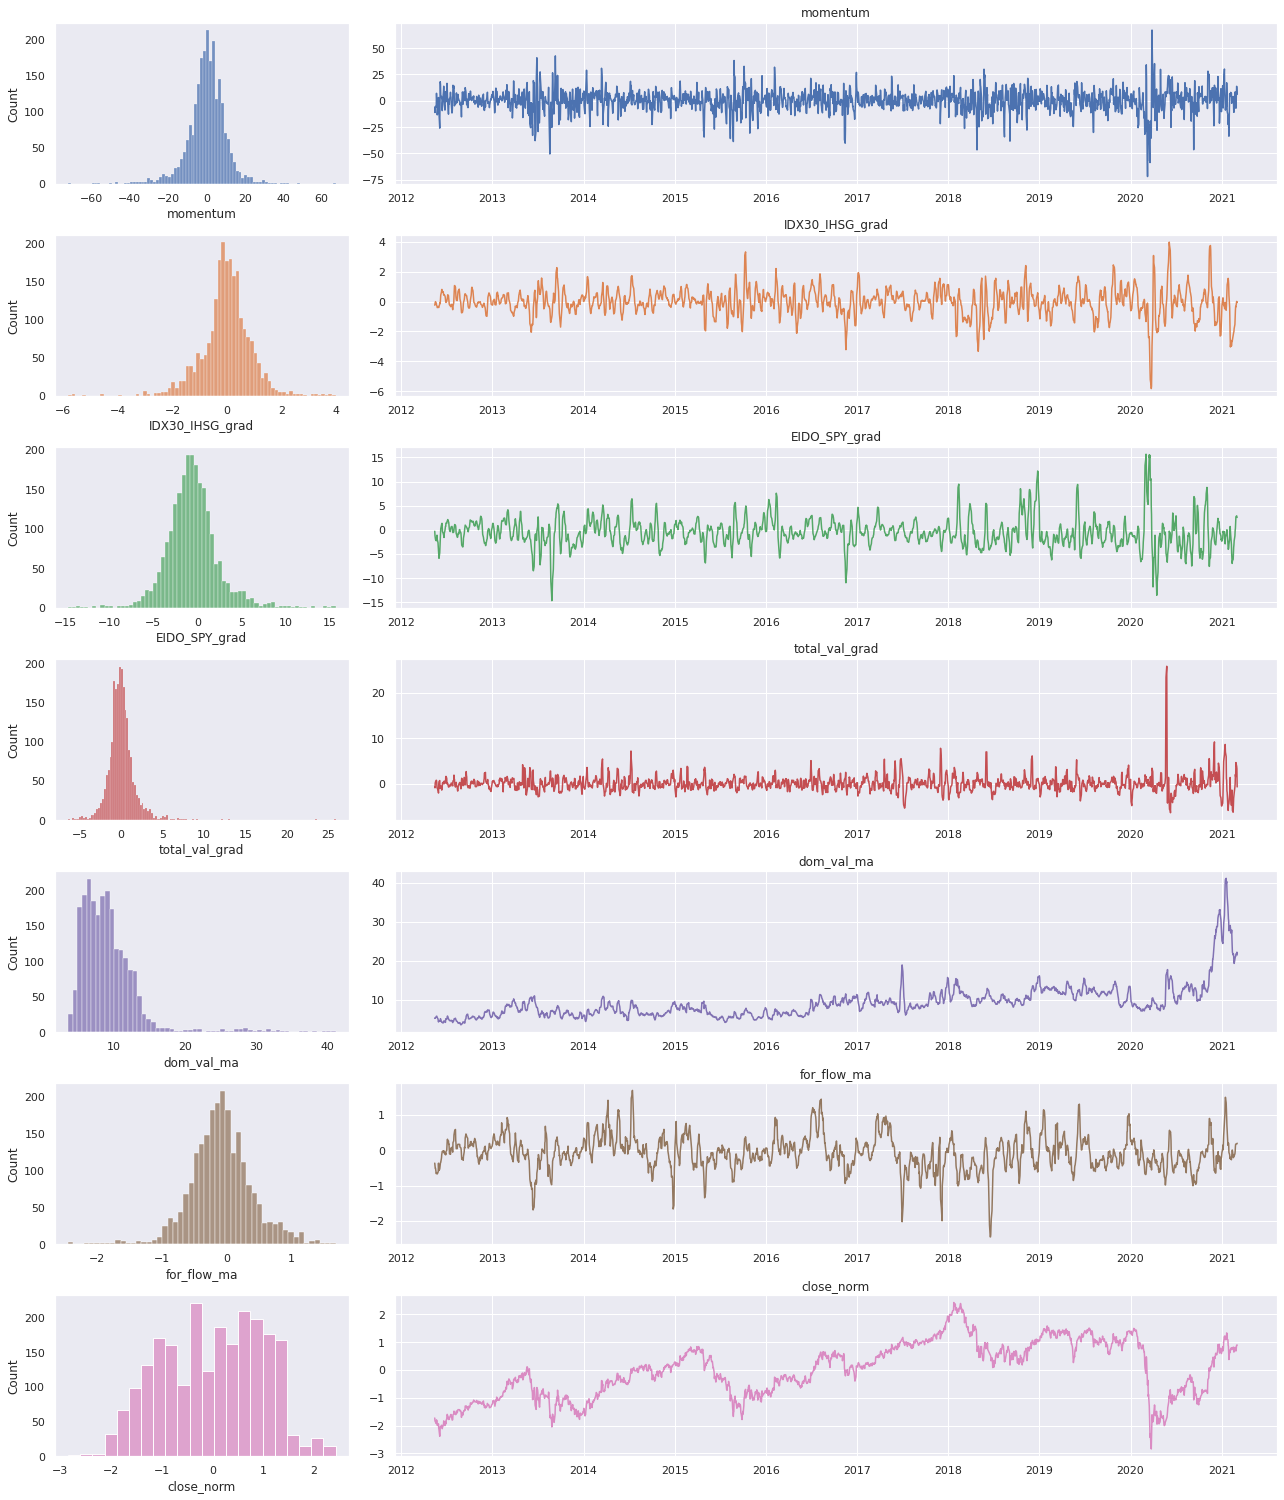

In [22]:
def plot_all(df, cols):
    fig, ax = plt.subplots(len(cols), 2, figsize=(18,len(cols)*3), gridspec_kw={'width_ratios': [1, 3]})
    colors = sns.color_palette()
    colors += colors
    for i, col in enumerate(cols):
        sns.histplot(df[col], ax=ax[i,0], color=colors[i])
        ax[i,1].plot(df.index, df[col], color=colors[i])
        ax[i,1].set_title(col)
        ax[i,0].grid()
#         ax[i,0].set_ylim(0,ylim)
    plt.tight_layout()
    
sns.set()
plot_all(df2, input_variables)

In [23]:
df_train = df2[(df2.index < '2019-01-01')].copy()
df_test = df2[(df2.index >= '2019-01-01') & (df2.index <= '2020-02-01')].copy()
df_test2 = df2[(df2.index >= '2020-01-01') & (df2.index <= '2021-02-01')].copy()
df_test3 = df2[(df2.index >= '2020-01-01') & (df2.index <= '2021-02-01')].copy()

# Unroll data
dates = df_train[(input_timesteps+output_timesteps-1):].index

# Separate train and test data
X_train, y_train = generate_batch(df_train, input_timesteps, output_timesteps, input_variables, target_variables)
######### DELETE LATER #########
lower_thresh = np.quantile(y_train, 0.4)
upper_thresh = np.quantile(y_train, 0.6)
# mask = (y_train < lower_thresh) | (y_train > upper_thresh)
# X_train = X_train[mask[:,0]]
# y_train = y_train[mask[:,0]]
# ######### DELETE LATER #########
X_test, y_test = generate_batch(df_test, input_timesteps, output_timesteps, input_variables, target_variables)
X_test2, y_test2 = generate_batch(df_test2, input_timesteps, output_timesteps,  input_variables, target_variables)
X_test3, y_test3 = generate_batch(df_test3, input_timesteps, output_timesteps,  input_variables, target_variables)

# Build LSTM Model using Tensorflow
model = create_model(neurons, output_timesteps, X_train.shape[1], X_train.shape[2], loss)
# model = multi_layer_model(multi_neurons[0],multi_neurons[1],output_timesteps,X_train.shape[1], X_train.shape[2],loss)
# model = multi_layer_model(multi_neurons[0],multi_neurons[1],output_timesteps,X_train.shape[1], X_train.shape[2],loss)

model_name = 'gru7_oneoff_n{neurons}_{feature_count}var_span{span}_X1.hdf5'.format(
                                                                                neurons=neurons,
                                                                                span=span,
                                                                                feature_count=len(input_variables))
model_path = 'temp_model/{}'.format(model_name)
mcp_save = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min',verbose=2)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=int(len(X_train)/1),
    validation_split=validation_split,
    verbose = 2, 
    shuffle=False,
    callbacks=[mcp_save]
)

new_model = tf.keras.models.load_model(model_path, compile=False)

Epoch 1/80
1/1 - 2s - loss: 1.2833 - sign_accuracy: 0.0000e+00 - val_loss: 0.3264 - val_sign_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.32638, saving model to temp_model/gru7_oneoff_n90_7var_span4_X1.hdf5
Epoch 2/80
1/1 - 0s - loss: 0.9535 - sign_accuracy: 0.0000e+00 - val_loss: 0.8846 - val_sign_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.32638
Epoch 3/80
1/1 - 0s - loss: 0.7608 - sign_accuracy: 0.0000e+00 - val_loss: 1.6809 - val_sign_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.32638
Epoch 4/80
1/1 - 0s - loss: 0.7135 - sign_accuracy: 0.0000e+00 - val_loss: 2.2130 - val_sign_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.32638
Epoch 5/80
1/1 - 0s - loss: 0.7215 - sign_accuracy: 0.0000e+00 - val_loss: 2.3332 - val_sign_accuracy: 0.0000e+00

Epoch 00005: val_loss did not improve from 0.32638
Epoch 6/80
1/1 - 0s - loss: 0.7199 - sign_accuracy: 0.0000e+00 - val_loss: 2.1611 - val_sign_accuracy: 0.00

In [24]:
# plot training history
hist = pd.DataFrame.from_dict(history.history)
# fig = go.Figure()

fig = make_subplots(rows=1, 
                    cols=2,
                    subplot_titles=("Train and Validation Loss per epoch", "Train and Validation Accuracy per epoch"))

# Plot Train and Validation Loss per epoch
fig.add_trace(go.Scatter(y=hist['loss'],
                         line=dict(color='blue')
                         ,name='train_loss'),
    row=1, col=1)
fig.add_trace(go.Scatter(y=hist['val_loss'],
                         line=dict(color='firebrick'),
                         name='val_loss'),
    row=1, col=1)

# Plot Train and Validation Accuracy per epoch
fig.add_trace(go.Scatter(y=hist['sign_accuracy'],
                         line=dict(color='blue'),
                         name='train'),
    row=1, col=2)
fig.add_trace(go.Scatter(y=hist['val_sign_accuracy'],
                         line=dict(color='firebrick'),
                         name='val'),
    row=1, col=2)

# Set x and y axes title
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)

fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_yaxes(title_text="Accuracy", row=1, col=2)


fig.show()

In [25]:
# Train-test target distributions
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_train['target']))
fig.add_trace(go.Histogram(x=df_test['target']))
fig.show()

# 5. Evaluate Model

In [26]:
df_train.Close[20:]

Date
2012-06-12    656.710
2012-06-13    657.700
2012-06-14    645.020
2012-06-15    650.250
2012-06-18    657.790
               ...   
2018-12-25    981.876
2018-12-26    980.050
2018-12-27    988.000
2018-12-28    982.730
2018-12-31    983.702
Name: Close, Length: 1710, dtype: float64

In [27]:
# Generate result from model
_,_,train_result = generate_prediction(new_model,X_train,y_train)
_,_,test_result = generate_prediction(new_model,X_test,y_test,df_test.index[(input_timesteps+output_timesteps-1):])
_,_,test_result2 = generate_prediction(new_model,X_test2,y_test2,df_test2.index[(input_timesteps+output_timesteps-1):])
_,_,test_result3 = generate_prediction(new_model,X_test3,y_test3,df_test3.index[(input_timesteps+output_timesteps-1):])

# Time-difference prediction and actual value
train_result['true'] = target_scaler.inverse_transform(train_result['true'])
train_result['pred'] = target_scaler.inverse_transform(train_result['pred'])
train_result['Close'] = df_train.Close[20:].values
train_result['close_norm'] = df_train.close_norm[20:].values

In [28]:
train_result

,Close,true_bin,pred_bin,true,pred,mse,squared_hinge,rolling_error,date,date_str,date_to_val,close_norm
0,656.710,-1,-1,650.250,764.399902,NaN,0.0,NaN,2012-05-01,2012-05-01,1709,-2.004393
1,657.700,-1,-1,657.790,764.399902,NaN,0.0,NaN,2012-05-01,2012-05-01,1709,-1.995160
2,645.020,-1,-1,662.420,764.399902,NaN,0.0,NaN,2012-05-01,2012-05-01,1709,-2.113423
3,650.250,-1,-1,675.290,764.399902,NaN,0.0,NaN,2012-05-01,2012-05-01,1709,-2.064644
4,657.790,-1,-1,667.530,764.399902,NaN,0.0,NaN,2012-05-01,2012-05-01,1709,-1.994320
...,...,...,...,...,...,...,...,...,...,...,...,...
1705,981.876,1,1,982.730,978.837708,0.361261,0.0,0.0,2012-05-01,2012-05-01,1709,1.028337
1706,980.050,1,1,983.702,978.837708,0.348596,0.0,0.0,2012-05-01,2012-05-01,1709,1.011307
1707,988.000,1,1,984.026,978.837708,0.300526,0.0,0.0,2012-05-01,2012-05-01,1709,1.085454
1708,982.730,1,1,984.350,978.837708,0.306569,0.0,0.0,2012-05-01,2012-05-01,1709,1.036302


In [29]:
train_result['true'] = (train_result['true']-train_result['Close'])/train_result['Close']
train_result['pred'] = (train_result['pred']-train_result['Close'])/train_result['Close']
train_result['true_bin'] = np.sign(train_result['true'])
train_result['pred_bin'] = np.sign(train_result['pred'])
train_result.true_bin.replace(0, 1, inplace=True)
train_result.pred_bin.replace(0, 1, inplace=True)

In [30]:
# Recalculate test result
test_result['true'] = target_scaler.inverse_transform(test_result['true'])
test_result['pred'] = target_scaler.inverse_transform(test_result['pred'])
test_result['Close'] = df_test.Close[20:].values
test_result['close_norm'] = df_test.close_norm[20:].values
test_result['true'] = (test_result['true']-test_result['Close'])/test_result['Close']
test_result['pred'] = (test_result['pred']-test_result['Close'])/test_result['Close']
test_result['true_bin'] = np.sign(test_result['true'])
test_result['pred_bin'] = np.sign(test_result['pred'])
test_result.true_bin.replace(0, 1, inplace=True)
test_result.pred_bin.replace(0, 1, inplace=True)

In [31]:
test_result

,Close,true_bin,pred_bin,true,pred,mse,squared_hinge,rolling_error,date,date_str,date_to_val,close_norm
0,1015.52,1.0,-1.0,0.025760,-0.036122,NaN,0.000000,NaN,2019-01-29,2019-01-29,0,1.342125
1,1023.54,1.0,-1.0,0.000498,-0.043674,NaN,0.000000,NaN,2019-01-30,2019-01-30,1,1.416926
2,1038.97,-1.0,-1.0,-0.008788,-0.057877,NaN,0.000000,NaN,2019-01-31,2019-01-31,2,1.560837
3,1041.68,-1.0,-1.0,-0.005808,-0.060328,NaN,0.000000,NaN,2019-02-01,2019-02-01,3,1.586112
4,1024.05,1.0,-1.0,0.008779,-0.044150,NaN,0.000000,NaN,2019-02-04,2019-02-04,4,1.421682
...,...,...,...,...,...,...,...,...,...,...,...,...
259,1003.79,-1.0,-1.0,-0.016527,-0.024858,1.968366,0.000000,0.000000,2020-01-27,2020-01-27,259,1.232723
260,1000.67,-1.0,-1.0,-0.038664,-0.021818,1.733850,0.024720,0.003531,2020-01-28,2020-01-28,260,1.203624
261,1000.32,-1.0,-1.0,-0.047045,-0.021475,1.545687,0.056909,0.011661,2020-01-29,2020-01-29,261,1.200359
262,987.20,-1.0,-1.0,-0.022650,-0.008471,1.241034,0.017044,0.014096,2020-01-30,2020-01-30,262,1.077993


In [32]:
# Train-test target distributions
fig = go.Figure()
fig.add_trace(go.Histogram(x=test_result['true']))
fig.add_trace(go.Histogram(x=test_result['pred']))
fig.show()

## 5.1 Train Result Evaluation

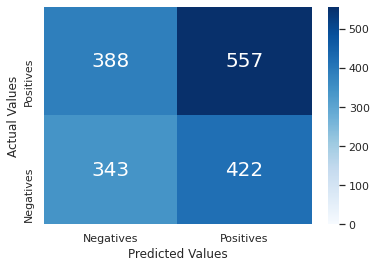

In [33]:
conf_matrix = confusion_matrix(train_result['true_bin'], train_result['pred_bin'])[::-1]
display_confusion_matrix(conf_matrix, reverse_ylabel=True)

In [34]:
print(classification_report(train_result['true_bin'],train_result['pred_bin'], target_names=['Negatives','Positives']))

              precision    recall  f1-score   support

   Negatives       0.47      0.45      0.46       765
   Positives       0.57      0.59      0.58       945

    accuracy                           0.53      1710
   macro avg       0.52      0.52      0.52      1710
weighted avg       0.52      0.53      0.53      1710



In [35]:
fig = px.scatter(train_result, x="pred", y="true", color="squared_hinge", 
                 trendline="ols",
                 title="Train Result",
                 width=800, height=800, hover_data=["date_str"])
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## 5.2 Test Result Evaluation

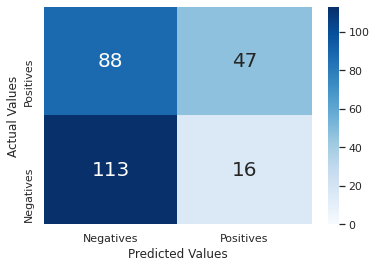

In [36]:
conf_matrix2 = confusion_matrix(test_result['true_bin'],test_result['pred_bin'])[::-1]
display_confusion_matrix(conf_matrix2, reverse_ylabel=True)

In [37]:
print(classification_report(test_result['pred_bin'], test_result['true_bin'], target_names=['Negatives','Positives']))

              precision    recall  f1-score   support

   Negatives       0.88      0.56      0.68       201
   Positives       0.35      0.75      0.47        63

    accuracy                           0.61       264
   macro avg       0.61      0.65      0.58       264
weighted avg       0.75      0.61      0.63       264



Text(30.5, 0.5, 'Actual Values')

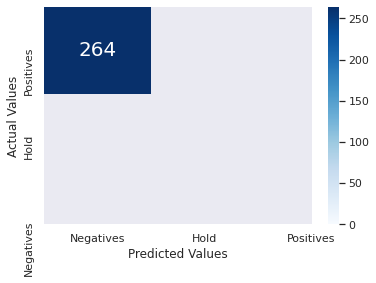

In [38]:
test_pred_ter = np.where(test_result['pred'] < lower_thresh,-1,np.where(test_result['pred'] > upper_thresh,1,0))
test_true_ter = np.where(test_result['true'] < lower_thresh,-1,np.where(test_result['true'] > upper_thresh,1,0))
conf_matrix = confusion_matrix(test_true_ter,test_pred_ter)[::-1]
labels = ['Negatives','Hold','Positives']
sns.heatmap(conf_matrix, 
                annot=True, 
                cmap="Blues",
                fmt="d",vmin=0, 
                annot_kws={"size": 20}, 
                xticklabels = labels, 
                yticklabels= labels[::-1])
plt.xlabel('Predicted Values', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Actual Values', fontsize = 12)

In [39]:
fig = px.scatter(test_result, x="pred", y="true", color="squared_hinge", 
                 trendline="ols",
                 title="Test Result",
                 width=800, height=800, hover_data=["date_str"])
fig.show()

#  6. Run Trading Simulation

In [40]:
def plot_returns(df):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[24, 12])
    
    # Add patch as legend
    red_patch = mpl.patches.Patch(color='#bb3f3f', label='Sell')
    green_patch = mpl.patches.Patch(color='#008000', label='Buy')
    
    # Closing price chart
    close = 100*df['Close']/df['Close'][0]
    sns.lineplot(data=close, ax=ax[0])
    ax[0].set_ylabel('Closing Price')
    buys = df.loc[df.position == 'Buy'] # mark buy transactions
    sells = df.loc[df.position == 'Sell'] # mark sell transactions
    
    # Add dashed line on last closing price
    last_closing_price = close[-1]
    ax[0].axhline(last_closing_price, ls='--',linewidth=1, color='m')
    ax[0].plot(buys.index, close.loc[buys.index], '.', markersize=8, color='g', label='buy')
    ax[0].plot(sells.index, close.loc[sells.index], '.', markersize=8, color='r', label='sell')
    ax[0].annotate((last_closing_price).round(2),xy=(1,last_closing_price),xycoords=('axes fraction','data'),ha='left',va='center',color='black')
    ax[0].grid(True)
    ax[0].legend(handles=[red_patch, green_patch])

    # Price change chart
    sns.lineplot(data=df[['target','pred']], ax=ax[1])
    ax[1].set_ylabel('target'.format(3))
    ax[1].grid(True)

    # Portfolio value
    port_value = df['value'] / df['value'][0]
    sns.lineplot(data=port_value, ax=ax[2])
    ax[2].set_ylabel('Portfolio Value')
    last_value = port_value[-1]
    ax[2].axhline(last_value, ls='--',linewidth=1, color='m')
    ax[2].annotate((last_value).round(2),xy=(1,last_value),xycoords=('axes fraction','data'),ha='left',va='center',color='black')
    ax[2].grid(True)

In [41]:
def simulate_position(df, buy_thresh, sell_thresh, buy_fee=0, sell_fee=0, closing_price_name='Close', consecutive_buy_thresh = 0, consecutive_sell_thresh = 0):
    temp = df.copy()
    # Mark position
    temp['buy_threshold'] = buy_thresh
    temp['sell_threshold'] = sell_thresh
    temp['position'] = 'Hold'
    temp.loc[temp['pred'] > buy_thresh,'position'] = 'Buy' # Buy action
    temp.loc[temp['pred'] < sell_thresh,'position'] = 'Sell' # Sell action
    # Simulate portfolio value
    temp['cash'] = 10000000
    temp['quantity'] = 0
    temp['equity'] = 0
    temp['trade_no'] = 0
    prev_pos = None
    prev_cash = 10000000
    prev_quantity, prev_equity = (0, 0)
    # Trade Count
    trade_count = 1
    consecutive_buys = 0
    consecutive_sells = 0
    for i, row in temp.iterrows():
        if (row['position'] == 'Buy') and (prev_pos != 'Buy') and (consecutive_buys >= consecutive_buy_thresh):
            temp.loc[i:,'trade_no'] = trade_count
            consecutive_buys = 1
            consecutive_sells = 0
            # Update position
            prev_pos = row['position']
            quantity = math.floor(prev_cash/row[closing_price_name])
            fee = quantity * row[closing_price_name] * buy_fee
            temp.at[i,'cash'] = prev_cash - (quantity*row[closing_price_name]) - fee
            temp.at[i,'quantity'] += quantity
            temp.at[i,'equity'] = quantity * row[closing_price_name]
            prev_cash = temp.at[i,'cash']
            prev_quantity = temp.at[i,'quantity']
            prev_equity = temp.at[i,'equity']
        elif (row['position'] == 'Sell') and (prev_pos == 'Buy') and (consecutive_sells >= consecutive_sell_thresh):
            temp.loc[i:,'trade_no'] = trade_count
            trade_count = trade_count + 1
            consecutive_sells = 1
            consecutive_buys = 0
            # Update position
            prev_pos = row['position']
            fee = prev_quantity * row[closing_price_name] * sell_fee
            temp.at[i,'cash'] = prev_quantity * row[closing_price_name] + prev_cash - fee
            temp.at[i,'quantity'] = 0
            temp.at[i,'equity'] = 0
            prev_cash = temp.at[i,'cash']
            prev_quantity = temp.at[i,'quantity']
            prev_equity = temp.at[i,'equity']
        elif (row['position'] == 'Buy') and (prev_pos == 'Buy'):
            consecutive_sells = 0
            consecutive_buys = consecutive_buys + 1
            # Update position
            temp.at[i,'cash'] = prev_cash
            temp.at[i,'quantity'] = prev_quantity
            temp.at[i,'equity'] = prev_quantity * row[closing_price_name]
        elif (row['position'] == 'Sell') and (prev_pos == 'Sell'):
            consecutive_buys = 0
            consecutive_sells = consecutive_sells + 1
            # Update position
            temp.at[i,'cash'] = prev_cash
            temp.at[i,'quantity'] = prev_quantity
            temp.at[i,'equity'] = prev_quantity * row[closing_price_name]
        else:
            consecutive_buys = 0
            consecutive_sells = 0
            # Update position
            temp.at[i,'cash'] = prev_cash
            temp.at[i,'quantity'] = prev_quantity
            temp.at[i,'equity'] = prev_quantity * row[closing_price_name]
    temp['value'] = temp['cash'] + temp['equity']
    return temp

In [42]:
test_result

,Close,true_bin,pred_bin,true,pred,mse,squared_hinge,rolling_error,date,date_str,date_to_val,close_norm
0,1015.52,1.0,-1.0,0.025760,-0.036122,NaN,0.000000,NaN,2019-01-29,2019-01-29,0,1.342125
1,1023.54,1.0,-1.0,0.000498,-0.043674,NaN,0.000000,NaN,2019-01-30,2019-01-30,1,1.416926
2,1038.97,-1.0,-1.0,-0.008788,-0.057877,NaN,0.000000,NaN,2019-01-31,2019-01-31,2,1.560837
3,1041.68,-1.0,-1.0,-0.005808,-0.060328,NaN,0.000000,NaN,2019-02-01,2019-02-01,3,1.586112
4,1024.05,1.0,-1.0,0.008779,-0.044150,NaN,0.000000,NaN,2019-02-04,2019-02-04,4,1.421682
...,...,...,...,...,...,...,...,...,...,...,...,...
259,1003.79,-1.0,-1.0,-0.016527,-0.024858,1.968366,0.000000,0.000000,2020-01-27,2020-01-27,259,1.232723
260,1000.67,-1.0,-1.0,-0.038664,-0.021818,1.733850,0.024720,0.003531,2020-01-28,2020-01-28,260,1.203624
261,1000.32,-1.0,-1.0,-0.047045,-0.021475,1.545687,0.056909,0.011661,2020-01-29,2020-01-29,261,1.200359
262,987.20,-1.0,-1.0,-0.022650,-0.008471,1.241034,0.017044,0.014096,2020-01-30,2020-01-30,262,1.077993


In [43]:
df_test

,Close,Open,High,Low,SPY,EIDO,IHSG,IDX30,Volume,for_flow,dom_total,tot_buy,dom_filtered,for_flow_filtered,total_buy_filtered,momentum,linear_series,target,close_norm,EIDO_SPY_diff,EIDO_SPY_ma,IDX30_IHSG_diff,IDX30_IHSG_ma,dom_val_ma,for_flow_ma,total_val_grad,EIDO_SPY_grad,IDX30_IHSG_grad,Volume_grad
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,984.026,984.946,987.948,980.714,182.106183,81.039508,148.280984,150.875912,0.846032,532280.125,13823943.00,9059479.750,13.823943,0.532280,9.059480,-0.5885,2.745,1.212670,1.048390,-101.066675,-98.903060,2.594929,3.046455,16.133925,0.132534,-0.192761,1.161928,-0.810139,-0.547692
2019-01-02,984.350,983.580,986.570,980.210,182.200859,81.703368,148.217056,150.930518,0.876880,207493.375,10639982.50,7477857.250,10.639983,0.207493,7.477857,0.6480,2.746,1.223303,1.051412,-100.497491,-99.940393,2.713462,2.903795,15.698235,0.280790,-1.243532,-1.362259,-1.028552,-0.446619
2019-01-03,990.880,983.090,990.880,981.160,177.853033,80.764249,149.172372,151.933471,0.963970,188355.750,9724555.50,7564971.250,9.724555,0.188356,7.564971,5.1405,2.747,1.173312,1.112315,-97.088785,-100.055273,2.761099,2.782771,14.699631,0.382278,-2.359459,-2.041504,-1.160199,-0.239883
2019-01-04,1001.640,988.400,1001.640,985.940,183.810356,84.067358,150.455957,153.599487,1.590000,393009.125,10713176.00,7521515.250,10.713176,0.393009,7.521515,11.4160,2.748,1.167249,1.212670,-99.742999,-100.113833,3.143530,2.731209,13.410119,0.468967,-2.925540,-2.364768,-0.703539,0.029912
2019-01-07,1002.780,1012.400,1017.830,1002.780,185.259631,84.520725,150.760008,153.630133,2.160000,398644.500,12525738.50,8656370.000,12.525738,0.398645,8.656370,7.8675,2.749,1.287191,1.223303,-100.738906,-100.113404,2.870125,2.668620,13.063315,0.490560,-2.241832,-2.451447,-0.433907,0.314208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-27,1003.790,1024.650,1024.910,1003.650,235.598281,81.832902,147.067033,153.106369,0.423540,161023.500,7573331.00,4927007.875,7.573331,0.161024,4.927008,-14.8900,3.024,1.077993,1.232723,-153.765380,-155.878245,6.039336,5.992699,8.050007,0.004343,-0.912708,-1.725457,0.914636,-0.131178
2020-01-28,1000.670,997.580,1001.670,989.390,238.067147,82.577720,146.538780,152.607678,0.474480,-469608.250,8798900.75,6698511.500,8.798901,-0.469608,6.698512,-12.9675,3.025,0.842773,1.203624,-155.489427,-155.842181,6.068898,6.049367,8.190696,-0.090911,-0.769396,-0.903989,0.686625,-0.113155
2020-01-29,1000.320,1003.670,1009.150,998.560,237.870512,82.318653,146.583380,152.621608,0.348770,69269.750,7231294.25,6317929.250,7.231294,0.069270,6.317929,-7.2500,3.026,0.761444,1.200359,-155.551859,-155.692273,6.038228,6.118666,7.967520,0.014515,-0.755113,-0.096623,0.551082,-0.109720


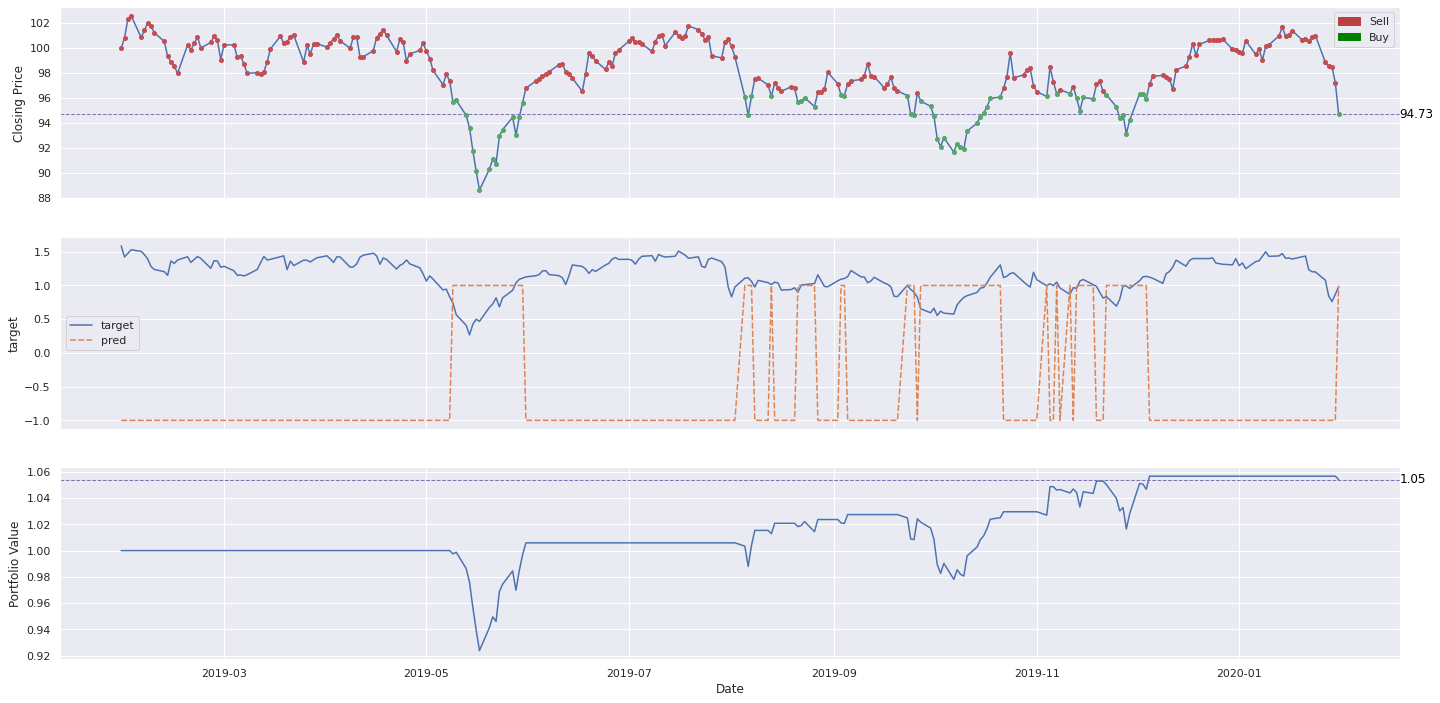

In [44]:
test_date = df_test[(input_timesteps+output_timesteps-1):].index
res = pd.DataFrame(test_date)
res['pred'] = test_result['pred_bin']
res = res.set_index(['Date'])
res = df_test.merge(res, how='inner', left_index=True, right_index=True).copy()

test_returns = simulate_position(res,0.15,-0.3,buy_fee=0.0025,sell_fee=0.003)#dp.generate_returns(res)
plot_returns(test_returns)

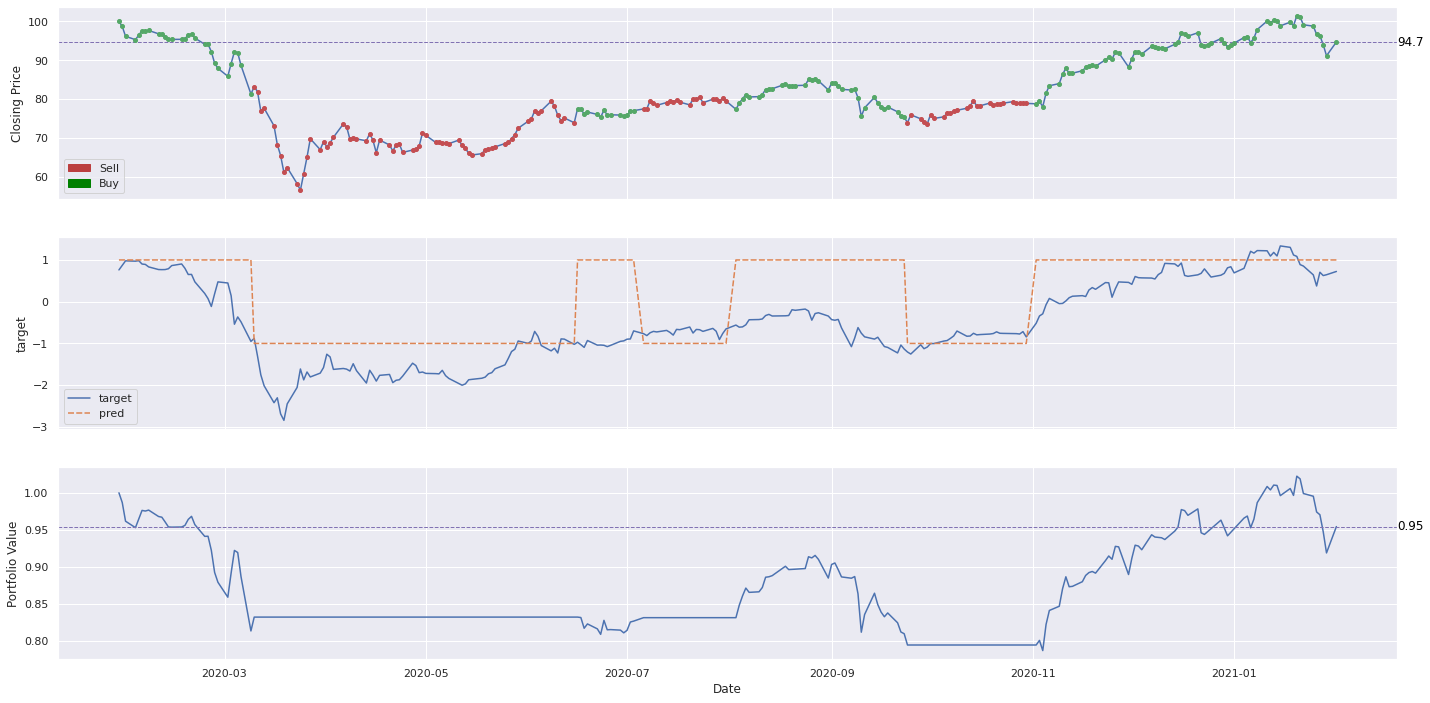

In [45]:
test_date2 = df_test2[(input_timesteps+output_timesteps-1):].index
res = pd.DataFrame(test_date2)
res['pred'] = test_result2['pred_bin']
res = res.set_index(['Date'])

res = df_test2.merge(res, how='inner', left_index=True, right_index=True).copy()

test_returns2 = simulate_position(res,lower_thresh,upper_thresh)#dp.generate_returns(res)
plot_returns(test_returns2)